# Cost Function Objective Comparison

This notebook compares ADAM optimization on GRAPE coefficients across three objectives:

- Terminal infidelity (objective='terminal')
- Ensemble robustness (objective='ensemble')
- Path-following fidelity (objective='path')

All runs share the same baseline pulses, harmonics, and optimizer hyperparameters. Results are collected for downstream analysis (pulse plots, Bloch dynamics, robustness heatmaps).

In [1]:
# Imports
from pathlib import Path
import sys
import os

notebook_dir = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
if str(repo_root) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root))
os.chdir(repo_root)

from typing import Any, Dict

import numpy as np

from src import override_from_dict, run_experiment
from src.notebook_runners import (
    build_base_config,
    method_options,
    prepare_baseline,
)


In [2]:
# Experiment parameters
max_iters = 200
grad_tol = 1e-10
rtol = 1e-10
max_time_min = 5.0

adam_learning_rate = 0.5
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
lr_decay = 1.0

power_weight = 5.0e-5
neg_weight = 1.0
neg_kappa = 10.0

K_OMEGA = 8
K_DELTA = 4

omega_shape = {'kind': 'polynomial', 'area_pi': 3.3}
delta_shape = {'kind': 'polynomial_chirp', 'area_pi': 0.0, 'amplitude_scale': 40.0}

artifact_root = Path('./artifacts')
run_name_base = 'objective-comparison'

OBJECTIVES = ('terminal', 'ensemble', 'path')


In [3]:
# Baseline setup
runner_ctx = prepare_baseline(
    omega_shape=omega_shape,
    delta_shape=delta_shape,
    K_omega=K_OMEGA,
    K_delta=K_DELTA,
)

penalties = {
    'power_weight': float(power_weight),
    'neg_weight': float(neg_weight),
    'neg_kappa': float(neg_kappa),
}

base_optimizer_common = {
    'max_iters': int(max_iters),
    'grad_tol': float(grad_tol),
    'rtol': float(rtol),
    'max_time_s': float(max_time_min) * 60.0,
    'optimize_delta': bool(K_DELTA > 0),
}

base_config, base_opts = build_base_config(
    runner_ctx.config,
    run_name=run_name_base,
    artifact_root=artifact_root,
    penalties=penalties,
    objective='terminal',
    base_optimizer_options=base_optimizer_common,
)

adam_overrides = {
    'learning_rate': float(adam_learning_rate),
    'beta1': float(beta1),
    'beta2': float(beta2),
    'epsilon': float(epsilon),
    'lr_decay': float(lr_decay),
}


In [4]:
# Run ADAM for each objective
results: Dict[str, Any] = {}

for objective in OBJECTIVES:
    run_label = f"{run_name_base}-{objective}"
    print(f"[adam][objective={objective}] starting optimization")

    base_opts_obj = dict(base_opts)
    base_opts_obj['method'] = 'adam'
    base_opts_obj.update(adam_overrides)

    objective_config = override_from_dict(
        base_config,
        {
            'metadata': {'objective': objective},
            'optimizer_options': base_opts_obj,
        },
    )

    result = run_experiment(
        objective_config,
        method='adam',
        run_name=run_label,
        exist_ok=True,
    )

    results[objective] = result
    print(f"[adam][objective={objective}] finished (status={result.optimizer_state.get('status')})")


[adam][objective=terminal] starting optimization
[adam][objective=terminal] finished (status=max_iters)
[adam][objective=ensemble] starting optimization
[adam][objective=ensemble] finished (status=max_iters)
[adam][objective=path] starting optimization
[adam][objective=path] finished (status=max_iters)


## Stage 2: Pulse Comparisons and Bloch Dynamics

In [5]:
# Additional imports for Stage 2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (enables 3D projection)

from src.physics import propagate_piecewise_const
from src.crab_notebook_utils import ground_state_projectors
from src.physics import bloch_components  # canonical Pauli-trace Bloch mapping

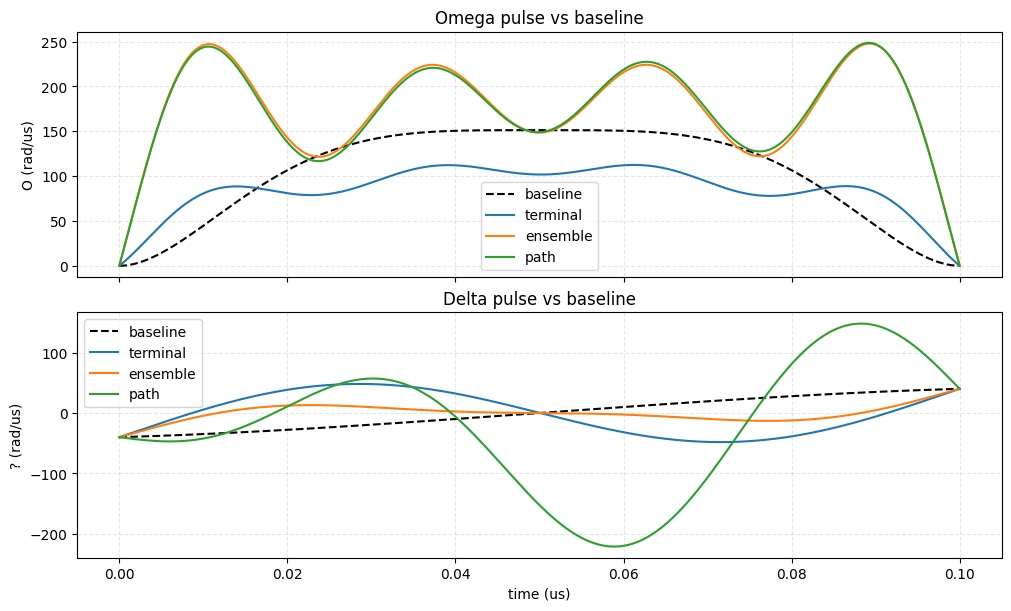

In [6]:
# Compare optimized pulses to baseline
if not results:
    print('Run the Stage 1 cell to generate results first.')
else:
    # Pull a consistent time grid and baseline from any result
    any_res = next(iter(results.values()))
    pulses_any = any_res.pulses
    t_us = np.asarray(pulses_any.get('t_us'), dtype=np.float64)
    omega_base = np.asarray(pulses_any.get('omega_base'), dtype=np.float64)
    delta_base = pulses_any.get('delta_base')
    delta_base = np.zeros_like(omega_base) if delta_base is None else np.asarray(delta_base, dtype=np.float64)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, constrained_layout=True)
    axes[0].plot(t_us, omega_base, 'k--', label='baseline')
    axes[1].plot(t_us, delta_base, 'k--', label='baseline')

    for objective, res in results.items():
        p = res.pulses
        omega = np.asarray(p.get('omega'), dtype=np.float64)
        delta = p.get('delta')
        delta = np.zeros_like(omega) if delta is None else np.asarray(delta, dtype=np.float64)
        axes[0].plot(t_us, omega, label=objective)
        axes[1].plot(t_us, delta, label=objective)

    axes[0].set_ylabel('O (rad/us)')
    axes[0].set_title('Omega pulse vs baseline')
    axes[0].grid(True, linestyle='--', alpha=0.3)
    axes[0].legend()

    axes[1].set_xlabel('time (us)')
    axes[1].set_ylabel('? (rad/us)')
    axes[1].set_title('Delta pulse vs baseline')
    axes[1].grid(True, linestyle='--', alpha=0.3)
    axes[1].legend()
    plt.show()


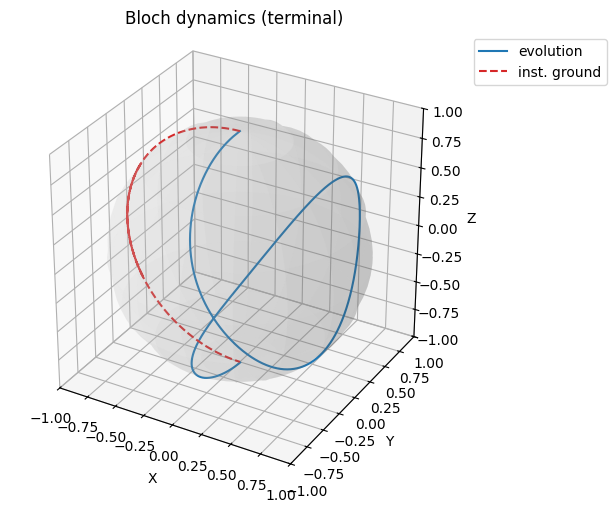

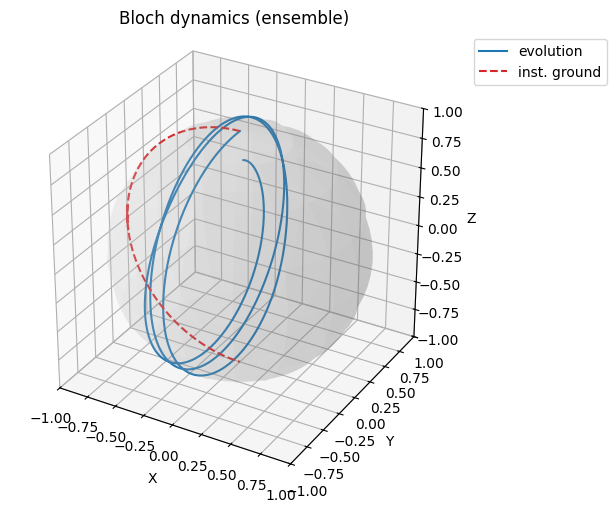

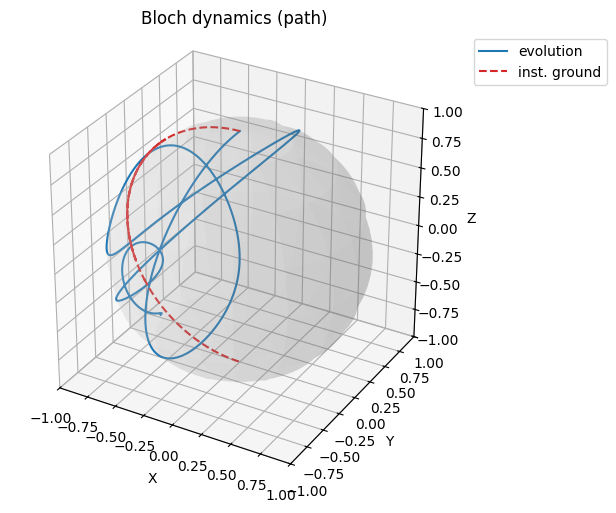

In [7]:
# Bloch-sphere dynamics with instantaneous ground-state trajectory (robust mapping)
if not results:
    print('Run the Stage 1 cell to generate results first.')
else:
    dt_us = float(runner_ctx.dt_us)

    # Precompute a unit-sphere wireframe for context
    import numpy as _np
    _u = _np.linspace(0, 2*_np.pi, 64)
    _v = _np.linspace(0, _np.pi, 32)
    _xs = _np.outer(_np.cos(_u), _np.sin(_v))
    _ys = _np.outer(_np.sin(_u), _np.sin(_v))
    _zs = _np.outer(_np.ones_like(_u), _np.cos(_v))

    for objective, res in results.items():
        p = res.pulses
        omega = np.asarray(p.get('omega'), dtype=np.float64)
        delta = p.get('delta')
        delta = np.zeros_like(omega) if delta is None else np.asarray(delta, dtype=np.float64)

        traj = propagate_piecewise_const(omega, delta, dt_us, psi0=runner_ctx.psi0)
        rho_path = np.asarray(traj['rho_path'])

        # Canonical Bloch mapping via Pauli traces
        bloch = np.stack([bloch_components(rho_path[k]) for k in range(rho_path.shape[0])], axis=0)

        # Instantaneous ground-state projectors and their Bloch vectors
        P_gs = ground_state_projectors(omega, delta)
        bloch_gs = np.stack([bloch_components(P_gs[k]) for k in range(P_gs.shape[0])], axis=0)

        fig = plt.figure(figsize=(6, 5))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(_xs, _ys, _zs, rstride=4, cstride=4, color='lightgray', alpha=0.15, linewidth=0)

        ax.plot(bloch[:,0], bloch[:,1], bloch[:,2], label='evolution', color='C0')
        ax.plot(bloch_gs[:,0], bloch_gs[:,1], bloch_gs[:,2], label='inst. ground', color='C3', linestyle='--')

        # Enforce equal axes and unit bounds
        ax.set_xlim(-1.0, 1.0)
        ax.set_ylim(-1.0, 1.0)
        ax.set_zlim(-1.0, 1.0)
        try:
            ax.set_box_aspect((1, 1, 1))
        except Exception:
            pass
        ax.set_title(f'Bloch dynamics ({objective})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
        plt.tight_layout()
        plt.show()